# 🚀 Snorkel Tutorial: Data Labeling and Augmentation for Spam Classification

In this tutorial, we will walk through the process of using Snorkel to build a training set for classifying YouTube comments as spam or not spam.
The goal of this tutorial is to illustrate the basic components and concepts of Snorkel in a simple way, but also to dive into the actual process of iteratively developing real applications in Snorkel.

**Note that this is a toy dataset that helps highlight the different features of Snorkel. For examples of high-performance, real-world uses of Snorkel, see [publications list](https://www.snorkel.org/resources/).**

Our goal is to train a classifier over the comment data that can predict whether a comment is spam or not spam.
We have access to a large amount of *unlabeled data* in the form of YouTube comments with some metadata.
In order to train a classifier, we need to label our data, but doing so by hand for real world applications can often be prohibitively slow and expensive.

In these cases, we can turn to a _weak supervision_ approach, using **_labeling functions (LFs)_** in Snorkel: noisy, programmatic rules and heuristics that assign labels to unlabeled training data.
We'll dive into the Snorkel API and how we write labeling functions later in this tutorial, but as an example,
we can write an LF that labels data points with `"http"` in the comment text as spam since many spam
comments contain links:

```python
from snorkel.labeling import labeling_function

@labeling_function()
def lf_contains_link(x):
    # Return a label of SPAM if "http" in comment text, otherwise ABSTAIN
    return SPAM if "http" in x.text.lower() else ABSTAIN
```

The tutorial is divided into four parts:
1. **Loading Data**: We load a [YouTube comments dataset](http://www.dt.fee.unicamp.br/~tiago//youtubespamcollection/), originally introduced in ["TubeSpam: Comment Spam Filtering on YouTube"](https://ieeexplore.ieee.org/document/7424299/), ICMLA'15 (T.C. Alberto, J.V. Lochter, J.V. Almeida).

2. **Writing Labeling Functions**: We write Python programs that take as input a data point and assign labels (or abstain) using heuristics, pattern matching, and third-party models.

3. **Combining Labeling Function Outputs with the Label Model**: We model the outputs of the labeling functions over the training set using a novel, theoretically-grounded [modeling approach](https://arxiv.org/abs/1605.07723), which estimates the accuracies and correlations of the labeling functions using only their agreements and disagreements, and then uses this to reweight and combine their outputs, which we then use as _probabilistic_ training labels.

4. **Training a Classifier**: We train a classifier that can predict labels for *any* YouTube comment (not just the ones labeled by the labeling functions) using the probabilistic training labels from step 3.

### Task: Spam Detection

We use a [YouTube comments dataset](http://www.dt.fee.unicamp.br/~tiago//youtubespamcollection/) that consists of YouTube comments from 5 videos. The task is to classify each comment as being

* **`HAM`**: comments relevant to the video (even very simple ones), or
* **`SPAM`**: irrelevant (often trying to advertise something) or inappropriate messages

For example, the following comments are `SPAM`:

        "Subscribe to me for free Android games, apps.."

        "Please check out my vidios"

        "Subscribe to me and I'll subscribe back!!!"

and these are `HAM`:

        "3:46 so cute!"

        "This looks so fun and it's a good song"

        "This is a weird video."

### Data Splits in Snorkel

We split our data into two sets:
* **Training Set**: The largest split of the dataset, and the one without any ground truth ("gold") labels.
We will generate labels for these data points with weak supervision.
* **Test Set**: A small, standard held-out blind hand-labeled set for final evaluation of our classifier. This set should only be used for final evaluation, _not_ error analysis.

Note that in more advanced production settings, we will often further split up the available hand-labeled data into a _development split_, for getting ideas to write labeling functions, and a _validation split_ for e.g. checking our performance without looking at test set scores, hyperparameter tuning, etc.  These splits are used in some of the other advanced tutorials, but omitted for simplicity here.

## 1. Loading Data

We load the YouTube comments dataset and create Pandas DataFrame objects for the train and test sets.
DataFrames are extremely popular in Python data analysis workloads, and Snorkel provides native support
for several DataFrame-like data structures, including Pandas, Dask, and PySpark.
For more information on working with Pandas DataFrames, see the [Pandas DataFrame guide](https://pandas.pydata.org/pandas-docs/stable/user_guide/dsintro.html).

Each DataFrame consists of the following fields:
* **`author`**: Username of the comment author
* **`data`**: Date and time the comment was posted
* **`text`**: Raw text content of the comment
* **`label`**: Whether the comment is `SPAM` (1), `HAM` (0), or `UNKNOWN/ABSTAIN` (-1)
* **`video`**: Video the comment is associated with

We start by loading our data.
The `load_spam_dataset()` method downloads the raw CSV files from the internet, divides them into splits, converts them into DataFrames, and shuffles them.
As mentioned above, the dataset contains comments from 5 of the most popular YouTube videos during a period between 2014 and 2015.
* The first four videos' comments are combined to form the `train` set. This set has no gold labels.
* The fifth video is part of the `test` set.

This next cell makes sure a spaCy English model is downloaded.
If this is your first time downloading this model, restart the kernel after executing the next cell.

In [382]:
# Download the spaCy english model
! python3 -m spacy download en_core_web_sm

You should consider upgrading via the 'pip install --upgrade pip' command.
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [383]:
#Downloading the dataset and loading it into the coding environment.
from utils import load_spam_dataset

df_train, df_test = load_spam_dataset()

#TODO: How big s the dataset? 
print(df_train.shape)
print(df_test.shape)

# We pull out the label vectors for ease of use later
Y_test = df_test.label.values
Y_train = df_train.label.values
print(set(Y_test))
print(set(Y_train)) #everything is -1 here, as we don't want to use these labels.

(1586, 5)
(250, 5)
{0, 1}
{-1.0}


The class distribution varies slightly between `SPAM` and `HAM`, but they're approximately class-balanced.

In [384]:
# For clarity, we define constants to represent the class labels for spam, ham, and abstaining.
ABSTAIN = -1
HAM = 0
SPAM = 1

## 2. Writing Labeling Functions (LFs)

### a) Exploring the training set for initial ideas

We'll start by looking at 20 random data points from the `train` set to generate some ideas for LFs.

In [385]:
df_train[["author", "text", "video", "label"]].sample(20, random_state=10)

,author,text,video,label
99,Santeri Saariokari,"Hey guys go to check my video name ""growtopia my story""﻿",2,-1.0
359,Lil M,"Hi I&#39;m lil m !!! Check out love the way you lie!!!! My live performance and many others,,, videos and my own lyrics!!!!! Thanks",4,-1.0
154,Tuấn Anh Nguyễn Tiến,1000000000 views.﻿,3,-1.0
428,Adela Korman,Check out my SEXY VIDEO :*,4,-1.0
219,andrewregino1,Check out this video on YouTube:﻿,4,-1.0
386,ItsJoey Dash,EVERYONE PLEASE SUBSCRIBE TO MY CHANNEL OR CAN YOU ALL JUST GO LOOK AT MY VIDEOS ﻿,3,-1.0
266,Evin Alshamas,Subscribe me please﻿,2,-1.0
39,awsome models,plese subscribe to me﻿,4,-1.0
16,Cléda Dimitri,http://www.rtbf.be/tv/emission/detail_the-voice-belgique/toutes-les-auditions/auditionDetail_?emissionId=3873&amp;id=342 Please join me to the voice Liked and shared it please to win more audition score. Thanks so much﻿,2,-1.0
227,Julia Szefer,Katty is the best! ! ! ! ﻿,2,-1.0


One dominant pattern in the comments that look like spam (which we might know from prior domain experience, or from inspection of a few training data points) is the use of the phrase "check out" (e.g. "check out my channel").
Let's start with that.

### b) Writing a few LFs

Labeling functions in Snorkel are created with the
[`@labeling_function` decorator](https://snorkel.readthedocs.io/en/master/packages/_autosummary/labeling/snorkel.labeling.labeling_function.html).
The [decorator](https://realpython.com/primer-on-python-decorators/) can be applied to _any Python function_ that returns a label for a single data point.


In [386]:
from snorkel.labeling import labeling_function
import re

@labeling_function()
def subscribe(x):
    return SPAM if "subscribe" in x.text.lower() else ABSTAIN

@labeling_function()
def help_me(x):
    return SPAM if "help" in x.text.lower() else ABSTAIN

@labeling_function()
def need_money(x):
    return SPAM if "money" in x.text.lower() else ABSTAIN

@labeling_function()
def http(x):
    return SPAM if "http" in x.text.lower() else ABSTAIN

@labeling_function()
def good(x):
    return HAM if "good" in x.text.lower() else ABSTAIN

@labeling_function()
def love(x):
    return HAM if "love" in x.text.lower() else ABSTAIN

@labeling_function()
def best(x):
    return HAM if "best" in x.text.lower() else ABSTAIN

@labeling_function()
def check_out(x):
    return SPAM if re.search(r"check.*out", x.text, flags=re.I) else ABSTAIN


from snorkel.preprocess import preprocessor
from textblob import TextBlob

@preprocessor(memoize=True)
def textblob_sentiment(x):
    scores = TextBlob(x.text)
    x.polarity = scores.sentiment.polarity
    x.subjectivity = scores.sentiment.subjectivity
    return x

@labeling_function(pre=[textblob_sentiment])
def textblob_subjectivity(x):
    return HAM if x.subjectivity >= 0.5 else ABSTAIN

@labeling_function()
def short_comment(x):
    """Ham comments are often short, such as 'cool video!'"""
    return HAM if len(x.text.split()) < 5 else ABSTAIN

from snorkel.preprocess.nlp import SpacyPreprocessor

# The SpacyPreprocessor parses the text in text_field and
# stores the new enriched representation in doc_field
spacy = SpacyPreprocessor(text_field="text", doc_field="doc", memoize=True)

@labeling_function(pre=[spacy])
def has_person(x):
    """Ham comments mention specific people and are short."""
    if len(x.doc) < 20 and any([ent.label_ == "PERSON" for ent in x.doc.ents]):
        return HAM
    else:
        return ABSTAIN

from snorkel.labeling.lf.nlp import nlp_labeling_function


@nlp_labeling_function()
def has_person_nlp(x):
    """Ham comments mention specific people and are short."""
    if len(x.doc) < 20 and any([ent.label_ == "PERSON" for ent in x.doc.ents]):
        return HAM
    else:
        return ABSTAIN


To apply one or more LFs that we've written to a collection of data points, we use an
[`LFApplier`](https://snorkel.readthedocs.io/en/master/packages/_autosummary/labeling/snorkel.labeling.LFApplier.html).
Because our data points are represented with a Pandas DataFrame in this tutorial, we use the
[`PandasLFApplier`](https://snorkel.readthedocs.io/en/master/packages/_autosummary/labeling/snorkel.labeling.PandasLFApplier.html).
Correspondingly, a single data point `x` that's passed into our LFs will be a [Pandas `Series` object](https://pandas.pydata.org/pandas-docs/stable/reference/series.html).

It's important to note that these LFs will work for any object with an attribute named `text`, not just Pandas objects.
Snorkel has several other appliers for different data point collection types which you can browse in the [API documentation](https://snorkel.readthedocs.io/en/master/packages/labeling.html).

The output of the `apply(...)` method is a ***label matrix***, a fundamental concept in Snorkel.
It's a NumPy array `L` with one column for each LF and one row for each data point, where `L[i, j]` is the label that the `j`th labeling function output for the `i`th data point.
We'll create a label matrix for the `train` set.

In [387]:
from snorkel.labeling import PandasLFApplier

lfs = [subscribe, help_me, need_money, http, love, good, best, check_out,
       textblob_subjectivity, short_comment, has_person_nlp]

applier = PandasLFApplier(lfs=lfs)
L_train = applier.apply(df=df_train)

100%|██████████| 1586/1586 [00:01<00:00, 935.28it/s]


### c) Evaluate performance on training set

Lots of statistics about labeling functions &mdash; like coverage &mdash; are useful when building any Snorkel application.
So Snorkel provides tooling for common LF analyses using the
[`LFAnalysis` utility](https://snorkel.readthedocs.io/en/master/packages/_autosummary/labeling/snorkel.labeling.LFAnalysis.html).
We report the following summary statistics for multiple LFs at once:

* **Polarity**: The set of unique labels this LF outputs (excluding abstains)
* **Coverage**: The fraction of the dataset the LF labels
* **Overlaps**: The fraction of the dataset where this LF and at least one other LF label
* **Conflicts**: The fraction of the dataset where this LF and at least one other LF label and disagree
* **Correct**: The number of data points this LF labels correctly (if gold labels are provided)
* **Incorrect**: The number of data points this LF labels incorrectly (if gold labels are provided)
* **Empirical Accuracy**: The empirical accuracy of this LF (if gold labels are provided)

For *Correct*, *Incorrect*, and *Empirical Accuracy*, we don't want to penalize the LF for data points where it abstained.
We calculate these statistics only over those data points where the LF output a label.
**Note that in our current setup, we can't compute these statistics because we don't have any ground-truth labels (other than in the test set, which we cannot look at). Not to worry—Snorkel's `LabelModel` will estimate them without needing any ground-truth labels in the next step!**

In [388]:
from snorkel.labeling import LFAnalysis

lfs = [subscribe, help_me, need_money, http, love, good, best, check_out,
       textblob_subjectivity, short_comment, has_person_nlp]

LFAnalysis(L=L_train, lfs=lfs).lf_summary()

,j,Polarity,Coverage,Overlaps,Conflicts
subscribe,0,[1],0.127364,0.090164,0.072509
help_me,1,[1],0.029634,0.026482,0.013241
need_money,2,[1],0.028373,0.026482,0.022068
http,3,[1],0.119168,0.092686,0.080706
love,4,[0],0.094578,0.088903,0.027112
good,5,[0],0.034048,0.029634,0.008827
best,6,[0],0.032156,0.024590,0.006305
check_out,7,[1],0.233922,0.098991,0.086381
textblob_subjectivity,8,[0],0.357503,0.244641,0.131778
short_comment,9,[0],0.225725,0.138714,0.066835


## 4. Combining Labeling Function Outputs with the Label Model

This tutorial demonstrates just a handful of the types of LFs that one might write for this task.
One of the key goals of Snorkel is _not_ to replace the effort, creativity, and subject matter expertise required to come up with these labeling functions, but rather to make it faster to write them, since **in Snorkel the labeling functions are assumed to be noisy, i.e. innaccurate, overlapping, etc.**
Said another way: the LF abstraction provides a flexible interface for conveying a huge variety of supervision signals, and the `LabelModel` is able to denoise these signals, reducing the need for painstaking manual fine-tuning.

Once we perform some LFs analysis and finalize our list,  we can now apply these once again with `LFApplier` to get the label matrices.
The Pandas format provides an easy interface that many practitioners are familiar with, but it is also less optimized for scale.
For larger datasets, more compute-intensive LFs, or larger LF sets, you may decide to use one of the other data formats
that Snorkel supports natively, such as Dask DataFrames or PySpark DataFrames, and their corresponding applier objects.
For more info, check out the [Snorkel API documentation](https://snorkel.readthedocs.io/en/master/packages/labeling.html).

In [389]:
applier = PandasLFApplier(lfs=lfs)
L_train = applier.apply(df=df_train)
L_test = applier.apply(df=df_test)

100%|██████████| 250/250 [00:00<00:00, 909.51it/s]


In [390]:
LFAnalysis(L=L_train, lfs=lfs).lf_summary()

,j,Polarity,Coverage,Overlaps,Conflicts
subscribe,0,[1],0.127364,0.090164,0.072509
help_me,1,[1],0.029634,0.026482,0.013241
need_money,2,[1],0.028373,0.026482,0.022068
http,3,[1],0.119168,0.092686,0.080706
love,4,[0],0.094578,0.088903,0.027112
good,5,[0],0.034048,0.029634,0.008827
best,6,[0],0.032156,0.024590,0.006305
check_out,7,[1],0.233922,0.098991,0.086381
textblob_subjectivity,8,[0],0.357503,0.244641,0.131778
short_comment,9,[0],0.225725,0.138714,0.066835


We see that our labeling functions vary in coverage, how much they overlap/conflict with one another, and almost certainly their accuracies as well.
We can view a histogram of how many LF labels the data points in our train set have to get an idea of our total coverage.

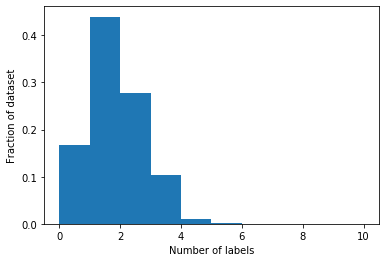

In [391]:
import matplotlib.pyplot as plt

%matplotlib inline


def plot_label_frequency(L):
    plt.hist((L != ABSTAIN).sum(axis=1), density=True, bins=range(L.shape[1]))
    plt.xlabel("Number of labels")
    plt.ylabel("Fraction of dataset")
    plt.show()


plot_label_frequency(L_train)

We see that over half of our `train` dataset data points have 2 or fewer labels from LFs.
Fortunately, the labels we do have can be used to train a classifier over the comment text directly, allowing this final machine learning model to generalize beyond what our labeling functions labeling.

Our goal is now to convert the labels from our LFs into a single _noise-aware_ probabilistic (or confidence-weighted) label per data point.
A simple baseline for doing this is to take the majority vote on a per-data point basis: if more LFs voted SPAM than HAM, label it SPAM (and vice versa).
We can test this with the
[`MajorityLabelVoter` baseline model](https://snorkel.readthedocs.io/en/master/packages/_autosummary/labeling/snorkel.labeling.model.baselines.MajorityLabelVoter.html#snorkel.labeling.model.baselines.MajorityLabelVoter).

However, as we can see from the summary statistics of our LFs in the previous section, they have varying properties and should not be treated identically. In addition to having varied accuracies and coverages, LFs may be correlated, resulting in certain signals being overrepresented in a majority-vote-based model. To handle these issues appropriately, we will instead use a more sophisticated Snorkel `LabelModel` to combine the outputs of the LFs.

This model will ultimately produce a single set of noise-aware training labels, which are probabilistic or confidence-weighted labels. We will then use these labels to train a classifier for our task. For more technical details of this overall approach, see our [NeurIPS 2016](https://arxiv.org/abs/1605.07723) and [AAAI 2019](https://arxiv.org/abs/1810.02840) papers. For more info on the API, see the [`LabelModel` documentation](https://snorkel.readthedocs.io/en/master/packages/_autosummary/labeling/snorkel.labeling.model.label_model.LabelModel.html#snorkel.labeling.model.label_model.LabelModel).

Note that no gold labels are used during the training process.
The only information we need is the label matrix, which contains the output of the LFs on our training set.
The `LabelModel` is able to learn weights for the labeling functions using only the label matrix as input.
We also specify the `cardinality`, or number of classes.

In [392]:
from snorkel.labeling.model import MajorityLabelVoter
from snorkel.labeling.model import LabelModel

majority_model = MajorityLabelVoter()
preds_train = majority_model.predict(L=L_train)

label_model = LabelModel(cardinality=2, verbose=True)
label_model.fit(L_train=L_train, n_epochs=500, log_freq=100, seed=123)

majority_acc = majority_model.score(L=L_test, Y=Y_test, tie_break_policy="random")["accuracy"]
print(f"{'Majority Vote Accuracy:':<25} {majority_acc * 100:.1f}%")

label_model_acc = label_model.score(L=L_test, Y=Y_test, tie_break_policy="random")["accuracy"]
print(f"{'Label Model Accuracy:':<25} {label_model_acc * 100:.1f}%")

Majority Vote Accuracy:   83.6%
Label Model Accuracy:     86.8%


The majority vote model or more sophisticated `LabelModel` could in principle be used directly as a classifier if the outputs of our labeling functions were made available at test time.
However, these models (i.e. these re-weighted combinations of our labeling function's votes) will abstain on the data points that our labeling functions don't cover (and additionally, may require slow or unavailable features to execute at test time).
In the next section, we will instead use the outputs of the `LabelModel` as training labels to train a discriminative classifier **which can generalize beyond the labeling function outputs** to see if we can improve performance further.
This classifier will also only need the text of the comment to make predictions, making it much more suitable for inference over unseen comments.
For more information on the properties of the label model, see the [Snorkel documentation](https://snorkel.readthedocs.io/en/master/packages/_autosummary/labeling/snorkel.labeling.model.label_model.LabelModel.html#snorkel.labeling.model.label_model.LabelModel).

Let's briefly confirm that the labels the `LabelModel` produces are indeed probabilistic in nature.
The following histogram shows the confidences we have that each data point has the label SPAM.
The points we are least certain about will have labels close to 0.5.

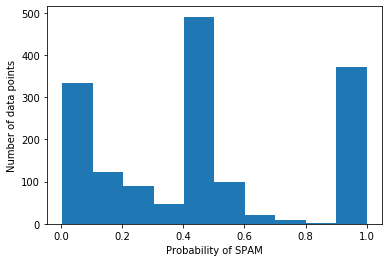

In [393]:


def plot_probabilities_histogram(Y):
    plt.hist(Y, bins=10)
    plt.xlabel("Probability of SPAM")
    plt.ylabel("Number of data points")
    plt.show()


probs_train = label_model.predict_proba(L=L_train)
plot_probabilities_histogram(probs_train[:, SPAM])

### Filtering out unlabeled data points

As we saw earlier, some of the data points in our `train` set received no labels from any of our LFs.
These data points convey no supervision signal and tend to hurt performance, so we filter them out before training using a
[built-in utility](https://snorkel.readthedocs.io/en/master/packages/_autosummary/labeling/snorkel.labeling.filter_unlabeled_dataframe.html#snorkel.labeling.filter_unlabeled_dataframe).

In [394]:
from snorkel.labeling import filter_unlabeled_dataframe

df_train_filtered, probs_train_filtered = filter_unlabeled_dataframe(
    X=df_train, y=probs_train, L=L_train
)

print(df_train.shape)
print(df_train_filtered.shape)

(1586, 5)
(1320, 5)


## 5. Training a Classifier

In this final section of the tutorial, we'll use the probabilistic training labels we generated in the last section to train a classifier for our task.
**The output of the Snorkel `LabelModel` is just a set of labels which can be used with most popular libraries for performing supervised learning, such as TensorFlow, Keras, PyTorch, Scikit-Learn, Ludwig, and XGBoost.**
In this tutorial, we use the well-known library [Scikit-Learn](https://scikit-learn.org).
**Note that typically, Snorkel is used (and really shines!) with much more complex, training data-hungry models, but we will use Logistic Regression here for simplicity of exposition.**

### Featurization

For simplicity and speed, we use a simple "bag of n-grams" feature representation: each data point is represented by a one-hot vector marking which words or 2-word combinations are present in the comment text.

In [395]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(ngram_range=(1, 5))
X_train = vectorizer.fit_transform(df_train_filtered.text.tolist())
X_test = vectorizer.transform(df_test.text.tolist())

print(X_train.shape)
print(X_test.shape)

(1320, 56734)
(250, 56734)


### Scikit-Learn Classifier

As we saw in Section 4, the `LabelModel` outputs probabilistic (float) labels.
If the classifier we are training accepts target labels as floats, we can train on these labels directly (see describe the properties of this type of "noise-aware" loss in our [NeurIPS 2016 paper](https://arxiv.org/abs/1605.07723)).

If we want to use a library or model that doesn't accept probabilistic labels (such as Scikit-Learn), we can instead replace each label distribution with the label of the class that has the maximum probability.
This can easily be done using the
[`probs_to_preds` helper method](https://snorkel.readthedocs.io/en/master/packages/_autosummary/utils/snorkel.utils.probs_to_preds.html#snorkel.utils.probs_to_preds).
We do note, however, that this transformation is lossy, as we no longer have values for our confidence in each label.

In [396]:
from snorkel.utils import probs_to_preds

preds_train_filtered = probs_to_preds(probs=probs_train_filtered)

We then use these labels to train a classifier as usual.

In [397]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

for classifier in [LogisticRegression(C=1e3, solver="liblinear"), LinearSVC()]:
    classifier.fit(X=X_train, y=preds_train_filtered)
    print("Performance for ", type(classifier).__name__), 
    print(f"Test Accuracy: {classifier.score(X=X_test, y=Y_test) * 100:.1f}%")


Performance for  LogisticRegression
Test Accuracy: 78.0%
Performance for  LinearSVC
Test Accuracy: 80.4%


**We observe an additional boost in accuracy over the `LabelModel` by multiple points! This is in part because the discriminative model generalizes beyond the labeling function's labels and makes good predictions on all data points, not just the ones covered by labeling functions.
By using the label model to transfer the domain knowledge encoded in our LFs to the discriminative model,
we were able to generalize beyond the noisy labeling heuristics**.

## Summary

In this tutorial, we accomplished the following:
* We introduced the concept of Labeling Functions (LFs) and demonstrated some of the forms they can take.
* We used the Snorkel `LabelModel` to automatically learn how to combine the outputs of our LFs into strong probabilistic labels.
* We showed that a classifier trained on a weakly supervised dataset can outperform an approach based on the LFs alone as it learns to generalize beyond the noisy heuristics we provide.

### Data Augmentation: Writing Transformation Functions (TFs)

Transformation functions are functions that can be applied to a training data point to create another valid training data point of the same class.
For example, for image classification problems, it is common to rotate or crop images in the training data to create new training inputs.
Transformation functions should be atomic e.g. a small rotation of an image, or changing a single word in a sentence.
We then compose multiple transformation functions when applying them to training data points.

Common ways to augment text includes replacing words with their synonyms, or replacing names entities with other entities.
More info can be found
[here](https://towardsdatascience.com/data-augmentation-in-nlp-2801a34dfc28) or
[here](https://towardsdatascience.com/these-are-the-easiest-data-augmentation-techniques-in-natural-language-processing-you-can-think-of-88e393fd610).
Our basic modeling assumption is that applying these operations to a comment generally shouldn't change whether it is `SPAM` or not.

Transformation functions in Snorkel are created with the
[`transformation_function` decorator](https://snorkel.readthedocs.io/en/master/packages/_autosummary/augmentation/snorkel.augmentation.transformation_function.html#snorkel.augmentation.transformation_function),
which wraps a function that takes in a single data point and returns a transformed version of the data point.
If no transformation is possible, a TF can return `None` or the original data point.
If all the TFs applied to a data point return `None`, the data point won't be included in
the augmented dataset when we apply our TFs below.

Just like the `labeling_function` decorator, the `transformation_function` decorator
accepts `pre` argument for `Preprocessor` objects.
Here, we'll use a
[`SpacyPreprocessor`](https://snorkel.readthedocs.io/en/master/packages/_autosummary/preprocess/snorkel.preprocess.nlp.SpacyPreprocessor.html#snorkel.preprocess.nlp.SpacyPreprocessor).

In [398]:
#Let us reload the dataset, with labels now. 
df_train, df_test = load_spam_dataset(load_train_labels=True)
# We pull out the label vectors for ease of use later
Y_train = df_train["label"].values
Y_test = df_test["label"].values

In [399]:
from snorkel.preprocess.nlp import SpacyPreprocessor

spacy = SpacyPreprocessor(text_field="text", doc_field="doc", memoize=True)

import names
from snorkel.augmentation import transformation_function

# Pregenerate some random person names to replace existing ones with
# for the transformation strategies below
replacement_names = [names.get_full_name() for _ in range(50)]


# Replace a random named entity with a different entity of the same type.
@transformation_function(pre=[spacy])
def change_person(x):
    person_names = [ent.text for ent in x.doc.ents if ent.label_ == "PERSON"]
    # If there is at least one person name, replace a random one. Else return None.
    if person_names:
        name_to_replace = np.random.choice(person_names)
        replacement_name = np.random.choice(replacement_names)
        x.text = x.text.replace(name_to_replace, replacement_name)
        return x


# Swap two adjectives at random.
@transformation_function(pre=[spacy])
def swap_adjectives(x):
    adjective_idxs = [i for i, token in enumerate(x.doc) if token.pos_ == "ADJ"]
    # Check that there are at least two adjectives to swap.
    if len(adjective_idxs) >= 2:
        idx1, idx2 = sorted(np.random.choice(adjective_idxs, 2, replace=False))
        # Swap tokens in positions idx1 and idx2.
        x.text = " ".join(
            [
                x.doc[:idx1].text,
                x.doc[idx2].text,
                x.doc[1 + idx1 : idx2].text,
                x.doc[idx1].text,
                x.doc[1 + idx2 :].text,
            ]
        )
        return x


We can add other wordnet based transformation funtions from NLTK. 

In [400]:
import nltk
from nltk.corpus import wordnet as wn

nltk.download("wordnet")


def get_synonym(word, pos=None):
    """Get synonym for word given its part-of-speech (pos)."""
    synsets = wn.synsets(word, pos=pos)
    # Return None if wordnet has no synsets (synonym sets) for this word and pos.
    if synsets:
        words = [lemma.name() for lemma in synsets[0].lemmas()]
        if words[0].lower() != word.lower():  # Skip if synonym is same as word.
            # Multi word synonyms in wordnet use '_' as a separator e.g. reckon_with. Replace it with space.
            return words[0].replace("_", " ")


def replace_token(spacy_doc, idx, replacement):
    """Replace token in position idx with replacement."""
    return " ".join([spacy_doc[:idx].text, replacement, spacy_doc[1 + idx :].text])


@transformation_function(pre=[spacy])
def replace_verb_with_synonym(x):
    # Get indices of verb tokens in sentence.
    verb_idxs = [i for i, token in enumerate(x.doc) if token.pos_ == "VERB"]
    if verb_idxs:
        # Pick random verb idx to replace.
        idx = np.random.choice(verb_idxs)
        synonym = get_synonym(x.doc[idx].text, pos="v")
        # If there's a valid verb synonym, replace it. Otherwise, return None.
        if synonym:
            x.text = replace_token(x.doc, idx, synonym)
            return x


@transformation_function(pre=[spacy])
def replace_noun_with_synonym(x):
    # Get indices of noun tokens in sentence.
    noun_idxs = [i for i, token in enumerate(x.doc) if token.pos_ == "NOUN"]
    if noun_idxs:
        # Pick random noun idx to replace.
        idx = np.random.choice(noun_idxs)
        synonym = get_synonym(x.doc[idx].text, pos="n")
        # If there's a valid noun synonym, replace it. Otherwise, return None.
        if synonym:
            x.text = replace_token(x.doc, idx, synonym)
            return x


@transformation_function(pre=[spacy])
def replace_adjective_with_synonym(x):
    # Get indices of adjective tokens in sentence.
    adjective_idxs = [i for i, token in enumerate(x.doc) if token.pos_ == "ADJ"]
    if adjective_idxs:
        # Pick random adjective idx to replace.
        idx = np.random.choice(adjective_idxs)
        synonym = get_synonym(x.doc[idx].text, pos="a")
        # If there's a valid adjective synonym, replace it. Otherwise, return None.
        if synonym:
            x.text = replace_token(x.doc, idx, synonym)
            return x

[nltk_data] Downloading package wordnet to /home/bangaru/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [401]:
tfs = [
    change_person,
    swap_adjectives,
    replace_verb_with_synonym,
    replace_noun_with_synonym,
    replace_adjective_with_synonym,
]
from utils import preview_tfs
import numpy as np

preview_tfs(df_train, tfs)

,TF Name,Original Text,Transformed Text
0,change_person,Check out Berzerk video on my channel ! :D,Check out Timothy Seymour video on my channel ! :D
1,swap_adjectives,hey guys look im aware im spamming and it pisses people off but please take a moment to check out my music. im a young rapper and i love to do it and i just wanna share my music with more people just click my picture and then see if you like my stuff,hey guys look im young im spamming and it pisses people off but please take a moment to check out my music. im a aware rapper and i love to do it and i just wanna share my music with more people just click my picture and then see if you like my stuff
2,replace_verb_with_synonym,"""eye of the tiger"" ""i am the champion"" seems like katy perry is using titles of old rock songs for lyrics..﻿","""eye of the tiger"" ""i be the champion"" seems like katy perry is using titles of old rock songs for lyrics..﻿"
3,replace_noun_with_synonym,"""eye of the tiger"" ""i am the champion"" seems like katy perry is using titles of old rock songs for lyrics..﻿","""eye of the tiger"" ""i am the champion"" seems like katy perry is using titles of old rock song for lyrics..﻿"
4,replace_adjective_with_synonym,"I started hating Katy Perry after finding out that she stole all of the ideas on her videos from an old comic book. Yet, her music is catchy. ﻿","I started hating Katy Perry after finding out that she stole all of the ideas on her videos from an old amusing book. Yet, her music is catchy. ﻿"


We notice a couple of things about the TFs.

    Sometimes they make trivial changes ("website" to "web site" for replace_noun_with_synonym). This can still be helpful for training our model, because it teaches the model to be invariant to such small changes.
    Sometimes they introduce incorrect grammar to the sentence (e.g. swap_adjectives swapping "young" and "more" above).

The TFs are expected to be heuristic strategies that indeed preserve the class most of the time, but don't need to be perfect. This is especially true when using automated data augmentation techniques which can learn to avoid particularly corrupted data points. As we'll see below, Snorkel is compatible with such learned augmentation policies.

3. Applying Transformation Functions

We'll first define a Policy to determine what sequence of TFs to apply to each data point. We'll start with a RandomPolicy that samples sequence_length=2 TFs to apply uniformly at random per data point. The n_per_original argument determines how many augmented data points to generate per original data point.


In [402]:
from snorkel.augmentation import RandomPolicy

random_policy = RandomPolicy(
    len(tfs), sequence_length=2, n_per_original=2, keep_original=True
)



In some cases, we can do better than uniform random sampling. We might have domain knowledge that some TFs should be applied more frequently than others, or have trained an automated data augmentation model that learned a sampling distribution for the TFs. Snorkel supports this use case with a MeanFieldPolicy, which allows you to specify a sampling distribution for the TFs. We give higher probabilities to the replace_[X]_with_synonym TFs, since those provide more information to the model.

In [403]:
from snorkel.augmentation import MeanFieldPolicy

mean_field_policy = MeanFieldPolicy(
    len(tfs),
    sequence_length=2,
    n_per_original=2,
    keep_original=True,
    p=[0.05, 0.05, 0.3, 0.3, 0.3],
)

In [404]:
#To apply one or more TFs that we've written to a collection of data points according to our policy, 
#we use a PandasTFApplier because our data points are represented with a Pandas DataFrame.

from snorkel.augmentation import PandasTFApplier

tf_applier = PandasTFApplier(tfs, mean_field_policy)

df_train_augmented = tf_applier.apply(df_train)

Y_train_augmented = df_train_augmented["label"].values

print(df_train.shape)
print(df_train_augmented.shape)


100%|██████████| 1586/1586 [00:28<00:00, 56.00it/s]


(1586, 5)
(2543, 5)


We have almost doubled our dataset using TFs! Note that despite n_per_original being set to 2, our dataset may not exactly triple in size, because sometimes TFs return None instead of a new data point (e.g. change_person when applied to a sentence with no persons). If you prefer to have exact proportions for your dataset, you can have TFs that can't perform a valid transformation return the original data point rather than None (as they do here).


4. Training A Model

Our final step is to use the augmented data to train a model. We can use the same classifier setup as before:
    
    

In [405]:
from sklearn.linear_model import LogisticRegression

from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(ngram_range=(1, 5))
X_train_augmented = vectorizer.fit_transform(df_train_augmented.text.tolist())

X_test = vectorizer.transform(df_test.text.tolist())

print(X_train_augmented.shape)
print(X_test.shape)
print(Y_train_augmented.shape)
print(set(Y_train_augmented))

for classifier in [LogisticRegression(C=1e3, solver="liblinear"), LinearSVC()]:
    classifier.fit(X=X_train_augmented, y=Y_train_augmented)
    print("Performance for ", type(classifier).__name__), 
    print(f"Test Accuracy: {classifier.score(X=X_test, y=Y_test) * 100:.1f}%")


(2543, 73338)
(250, 73338)
(2543,)
{0, 1}
Performance for  LogisticRegression
Test Accuracy: 88.4%
Performance for  LinearSVC
Test Accuracy: 92.8%


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [406]:
#Performance of the dataset, with known labels, with some basic feature engineering
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(ngram_range=(1, 5))
X_train = vectorizer.fit_transform(df_train.text.tolist())
X_test = vectorizer.transform(df_test.text.tolist())

print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)

for classifier in [LogisticRegression(C=1e3, solver="liblinear"), LinearSVC()]:
    classifier.fit(X=X_train, y=Y_train)
    print("Performance for ", type(classifier).__name__), 
    print(f"Test Accuracy: {classifier.score(X=X_test, y=Y_test) * 100:.1f}%")



(1586, 64101)
(250, 64101)
(1586,)
Performance for  LogisticRegression
Test Accuracy: 88.4%
Performance for  LinearSVC
Test Accuracy: 93.2%


so, was this a useful exercise?